In [17]:
import pandas as pd
import itertools
import random
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, text
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [18]:
#Create Database Connection
engine = create_engine("sqlite:///Resources/spotify_2023.sqlite", echo=False)

In [19]:
%ls

 Volume in drive C is OS
 Volume Serial Number is 32CC-3519

 Directory of c:\Users\npwol\OneDrive\Desktop\leaflet-challenge\Final-Project-Spotify

10/10/2024  07:43 PM    <DIR>          .
10/09/2024  09:57 PM    <DIR>          ..
10/09/2024  08:17 PM             3,028 Leo_Spotify.ipynb
10/10/2024  09:10 PM           692,686 Noah_Spotify.ipynb
10/09/2024  08:08 PM    <DIR>          Resources
10/10/2024  07:35 PM           294,011 spotify_cleaned.ipynb
               3 File(s)        989,725 bytes
               3 Dir(s)  806,387,658,752 bytes free


In [20]:
#Refelect Database into ORM Classes
Base = automap_base()
Base.prepare(autoload_with=engine, reflect=True)
Base.classes.keys()

C:\Users\npwol\AppData\Local\Temp\ipykernel_42168\2310885986.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(autoload_with=engine, reflect=True)


['cleaned_spotify_2023']

In [21]:
cleaned_spotify_2023 = Base.classes.cleaned_spotify_2023

In [22]:
session = Session(engine)

In [23]:
#get a list of column names and types
inspector = inspect(engine)
columns = inspector.get_columns('cleaned_spotify_2023')

for col in columns:
    print(col['name'], col['type'])

ID INTEGER
track_name TEXT
artist(s)_name TEXT
contributing_artist_count INTEGER
released_year INTEGER
released_month INTEGER
in_spotify_playlists INTEGER
spotify_chart_rank INTEGER
streams INTEGER
in_apple_playlists INTEGER
apple_chart_rank INTEGER
in_deezer_playlists INTEGER
deezer_chart_rank INTEGER
shazam_chart_rank INTEGER
bpm INTEGER
key TEXT
mode TEXT
danceability_% INTEGER
valence_% INTEGER
energy_% INTEGER
acousticness_% INTEGER
instrumentalness_% INTEGER
liveness_% INTEGER
speechiness_% INTEGER


In [24]:
# Assuming df is your DataFrame after loading the data from the SQLAlchemy engine
clean_spotify_df = pd.read_sql_table('cleaned_spotify_2023', engine)

col_list = []
for col in clean_spotify_df.columns:
    col_list.append(str(col))
clean_spotify_df.columns=col_list

# Rename 'artist(s)_name' to 'artists_name'
cleaned_spotify_df = clean_spotify_df.rename(columns={'artist(s)_name': 'artists_name',
                        'danceability_%': 'danceability',
                        'valence_%': 'valence',
                        'energy_%': 'energy', 
                        'acousticness_%': 'acousticness', 
                        'instrumentalness_%': 'instrumentalness',  
                        'liveness_%': 'liveness',
                        'speechiness_%': 'speechiness'
                        })

# Verify the change
print(cleaned_spotify_df.columns)

Index(['ID', 'track_name', 'artists_name', 'contributing_artist_count',
       'released_year', 'released_month', 'in_spotify_playlists',
       'spotify_chart_rank', 'streams', 'in_apple_playlists',
       'apple_chart_rank', 'in_deezer_playlists', 'deezer_chart_rank',
       'shazam_chart_rank', 'bpm', 'key', 'mode', 'danceability', 'valence',
       'energy', 'acousticness', 'instrumentalness', 'liveness',
       'speechiness'],
      dtype='object')


In [25]:
cleaned_spotify_df.head()

,ID,track_name,artists_name,contributing_artist_count,released_year,released_month,in_spotify_playlists,spotify_chart_rank,streams,in_apple_playlists,...,bpm,key,mode,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness
0,1,seven feat latto explicit ver,latto jung kook,2,2023,7,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,2,lala,myke towers,1,2023,3,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,3,vampire,olivia rodrigo,1,2023,6,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,4,cruel summer,taylor swift,1,2019,8,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,5,where she goes,bad bunny,1,2023,5,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [26]:
cleaned_spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817 entries, 0 to 816
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         817 non-null    int64 
 1   track_name                 815 non-null    object
 2   artists_name               817 non-null    object
 3   contributing_artist_count  817 non-null    int64 
 4   released_year              817 non-null    int64 
 5   released_month             817 non-null    int64 
 6   in_spotify_playlists       817 non-null    int64 
 7   spotify_chart_rank         817 non-null    int64 
 8   streams                    817 non-null    int64 
 9   in_apple_playlists         817 non-null    int64 
 10  apple_chart_rank           817 non-null    int64 
 11  in_deezer_playlists        817 non-null    int64 
 12  deezer_chart_rank          817 non-null    int64 
 13  shazam_chart_rank          817 non-null    int64 
 14  bpm       

In [27]:
# X.columns = X.columns.astype(str)  

# Step 1: Assume 'cleaned_spotify_db' is your DataFrame and exclude 'key' and 'mode'
X = cleaned_spotify_df.drop(columns=['ID', 'streams', 'track_name', 'artists_name', 'key', 'mode'])


# Target variable
y = cleaned_spotify_df['streams']
# y.columns = y.columns.astype(str)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

# Step 4: Convert scaled data back to DataFrames to retain feature names
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Step 5: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 7: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Mean Squared Error: 3.683205284690256e+16
Root Mean Squared Error: 191916786.25618595
Mean Absolute Error: 129245927.86343902
R² Score: 0.8187145894922314


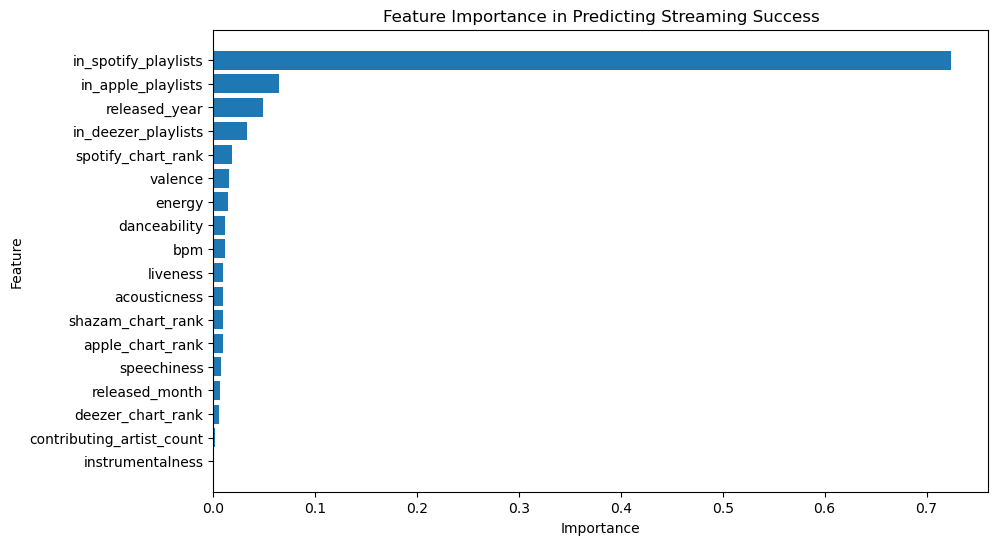

In [28]:
# Extract feature importances
importances = rf.feature_importances_

# Create a DataFrame to associate features with their importance
feature_names = X_train.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Streaming Success')
plt.gca().invert_yaxis()  
plt.show()


Mean Squared Error: 2.3603953398863408e+17
Root Mean Squared Error: 485839000.06960547
Mean Absolute Error: 362384245.3866829
R² Score: -0.1617740665462375


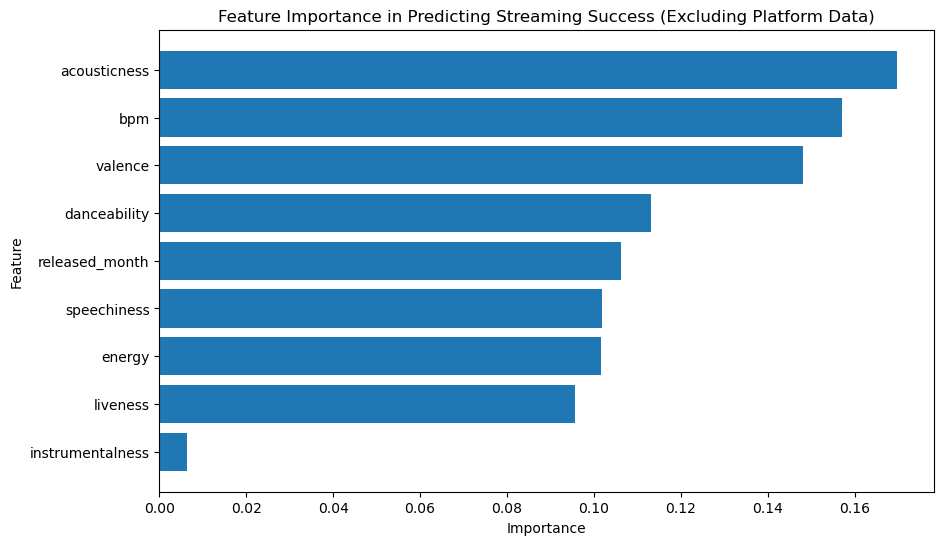

In [29]:
# Assuming 'cleaned_spotify_df' is your DataFrame
X = cleaned_spotify_df.drop(columns=[
    'ID', 'streams', 'track_name', 'artists_name', 
    'in_spotify_playlists', 'spotify_chart_rank', 
    'in_apple_playlists', 'apple_chart_rank', 
    'in_deezer_playlists', 'deezer_chart_rank', 
    'shazam_chart_rank', 'key', 'mode', 'released_year', 'contributing_artist_count'])

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 5: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 6: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 7: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_train.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Streaming Success (Excluding Platform Data)')
plt.gca().invert_yaxis()  
plt.show()


Mean Squared Error: 3.8735907960644056e+16
Root Mean Squared Error: 196814399.77970123
Mean Absolute Error: 130622417.04935977
R² Score: 0.8093439156045563


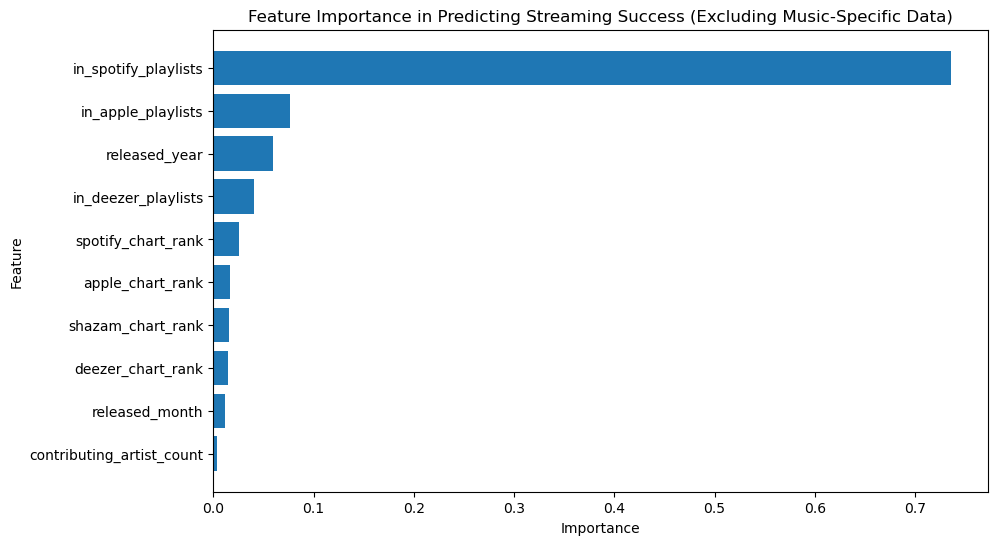

In [30]:
# Assuming 'cleaned_spotify_df' is your DataFrame
X = cleaned_spotify_df.drop(columns=[
    'ID', 'streams', 'track_name', 
    'bpm', 'key', 'mode', 'danceability', 'valence', 'energy', 
    'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'artists_name'])

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns (no non-numeric columns included now)
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 5: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 6: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 7: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_train.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Streaming Success (Excluding Music-Specific Data)')
plt.gca().invert_yaxis()  
plt.show()


Mean Squared Error: 5.092515858917296e+16
Root Mean Squared Error: 225666033.30845553
Mean Absolute Error: 158784477.31942013
R² Score: 0.74934907053958


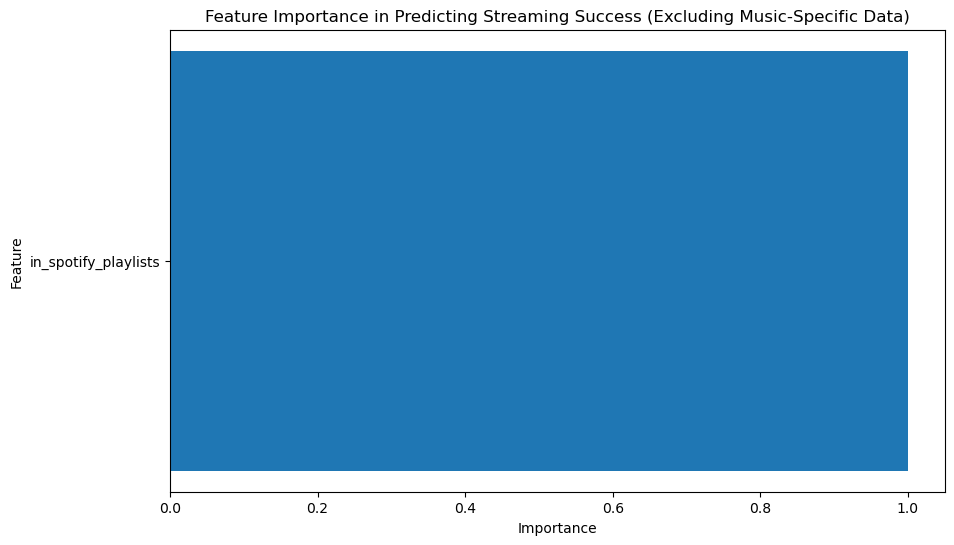

In [31]:
# Assuming 'cleaned_spotify_df' is your DataFrame
X = cleaned_spotify_df.drop(columns=['ID', 'streams', 'track_name', 
    'bpm', 'key', 'mode', 'danceability', 'valence', 'energy', 
    'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'artists_name', 
    'spotify_chart_rank', 'in_apple_playlists', 'apple_chart_rank', 
    'in_deezer_playlists', 'deezer_chart_rank', 'shazam_chart_rank', 
    'released_year', 'released_month', 'contributing_artist_count'])

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns (no non-numeric columns included now)
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 5: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 6: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 7: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_train.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Streaming Success (Excluding Music-Specific Data)')
plt.gca().invert_yaxis()  
plt.show()


Mean Squared Error: 3.603117396565782e+16
Root Mean Squared Error: 189818792.44600052
Mean Absolute Error: 127787229.38599391
R² Score: 0.8226564728663932


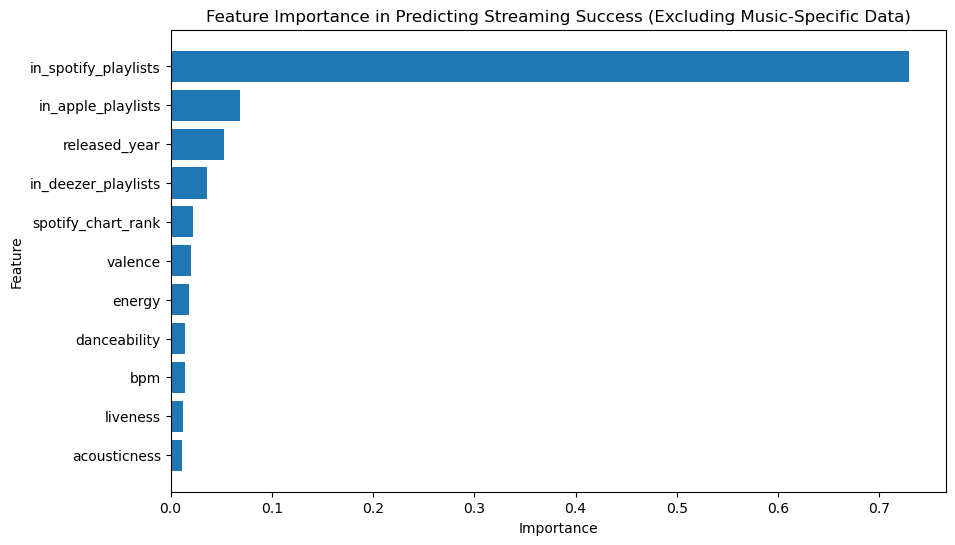

In [32]:
# Assuming 'cleaned_spotify_df' is your DataFrame
X = cleaned_spotify_df[['in_spotify_playlists', 'in_apple_playlists', 'released_year', 
                        'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
                        'energy', 'danceability', 'bpm', 'liveness', 'acousticness']]

# Target variable
y = cleaned_spotify_df['streams']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Step 3: Scale the numeric columns (no non-numeric columns included now)
scaler = StandardScaler()

# Fit the scaler on X_train and apply the transformation to both training and testing sets
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=7)
rf.fit(X_train_scaled, y_train)

# Step 5: Make predictions on the test set
y_pred = rf.predict(X_test_scaled)

# Step 6: Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Step 7: Evaluate feature importance
importances = rf.feature_importances_
feature_names = X_train.columns  
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Streaming Success (Excluding Music-Specific Data)')
plt.gca().invert_yaxis()  
plt.show()


In [36]:
# Sort the DataFrame by 'streams' in descending order to get the most streamed tracks
sorted_df = cleaned_spotify_df.sort_values(by='streams', ascending=False)

# Select the top 5 most streamed tracks and include the audio qualities and features of streaming
top_streamed_tracks = sorted_df[['track_name', 'artists_name', 'streams', 
                                 'in_spotify_playlists', 'in_apple_playlists', 
                                 'released_year', 'in_deezer_playlists', 
                                 'spotify_chart_rank', 'valence', 'energy', 
                                 'danceability', 'bpm', 'liveness', 'acousticness']].head(5)

# Save the result to the 'top_streamed_tracks' variable
top_str = top_streamed_tracks

# Print the top 5 most streamed tracks with additional features
print("Top 5 Most Streamed Tracks with Audio Qualities and Streaming Features:")
print(top_str)


Top 5 Most Streamed Tracks with Audio Qualities and Streaming Features:
                                    track_name                 artists_name  \
151                               shape of you                   ed sheeran   
36   sunflower  spiderman into the spiderverse         post malone swae lee   
137                                  one dance            drake wizkid kyla   
71                     stay with justin bieber  justin bieber the kid laroi   
122                                   believer              imagine dragons   

        streams  in_spotify_playlists  in_apple_playlists  released_year  \
151  3562543890                 32181                  33           2017   
36   2808096550                 24094                 372           2018   
137  2713922350                 43257                 433           2016   
71   2665343922                 17050                 492           2021   
122  2594040133                 18986                 250           2017 

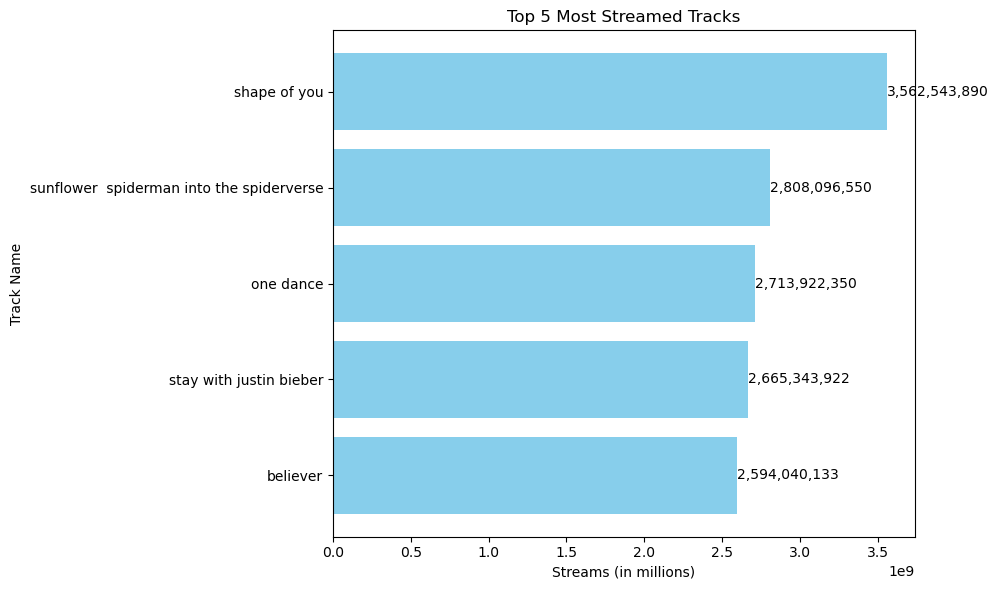

In [38]:
# Sort the DataFrame by 'streams' in descending order
top_streamed_tracks_sorted = top_streamed_tracks.sort_values(by='streams', ascending=True)

# Create a bar graph for stream counts
plt.figure(figsize=(10, 6))

# Horizontal bar graph for 'streams' in descending order
plt.barh(top_streamed_tracks_sorted['track_name'], top_streamed_tracks_sorted['streams'], color='skyblue')

# Add labels and title
plt.xlabel('Streams (in millions)')
plt.ylabel('Track Name')
plt.title('Top 5 Most Streamed Tracks')

# Display stream count on the bars
for index, value in enumerate(top_streamed_tracks_sorted['streams']):
    plt.text(value, index, f'{value:,.0f}', va='center')

# Show the plot
plt.tight_layout()
plt.show()


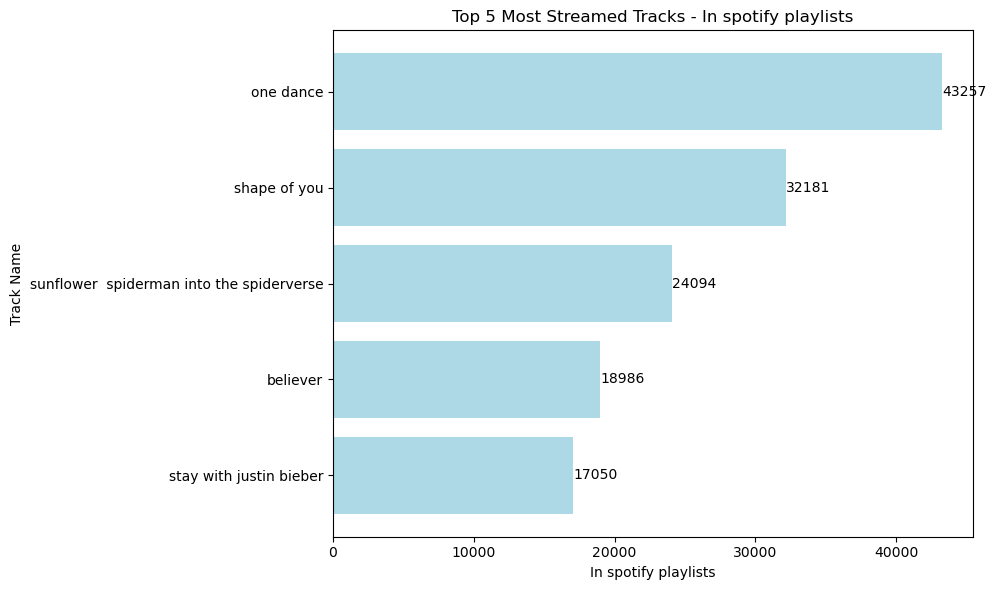

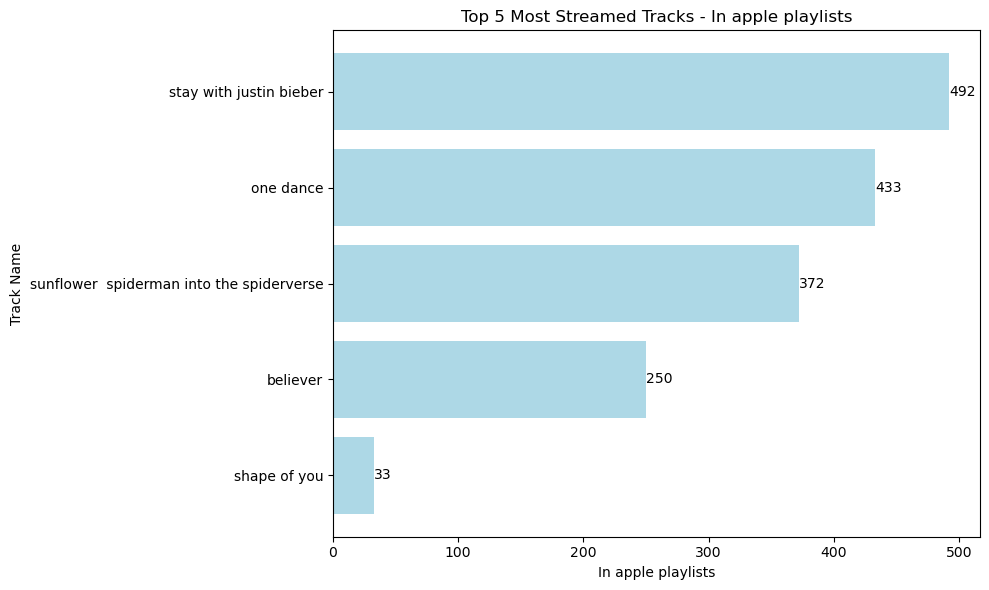

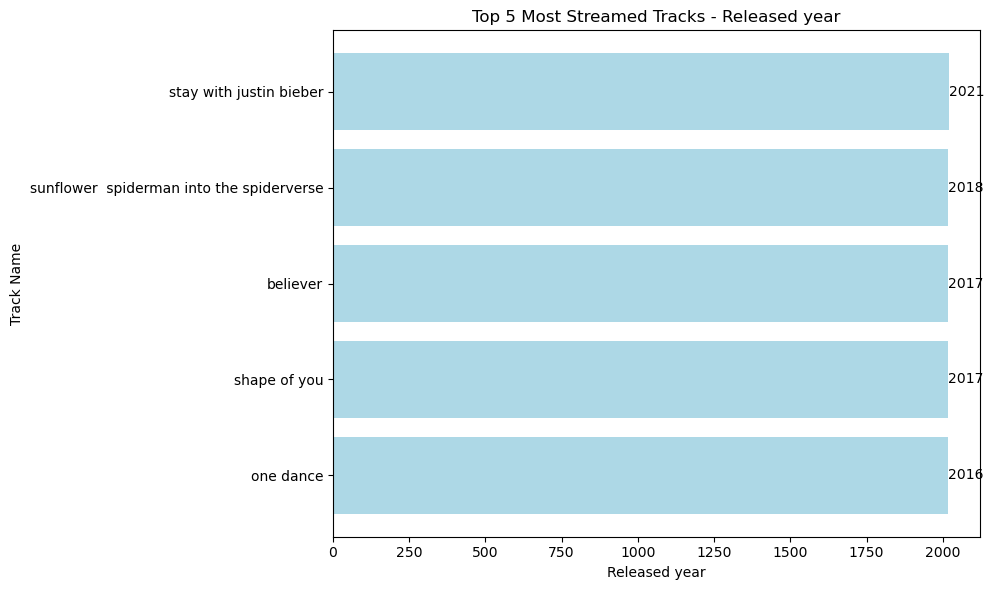

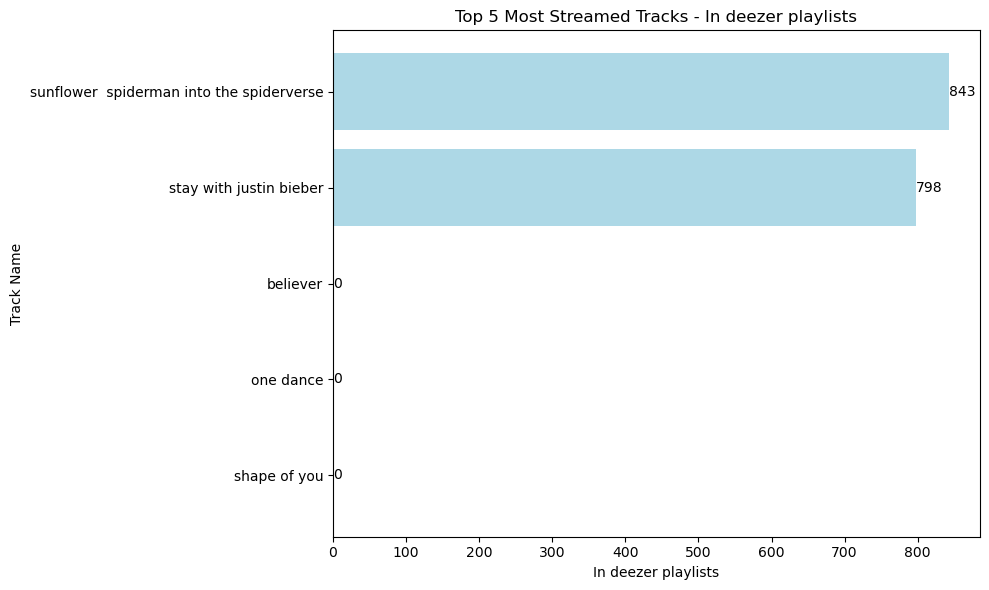

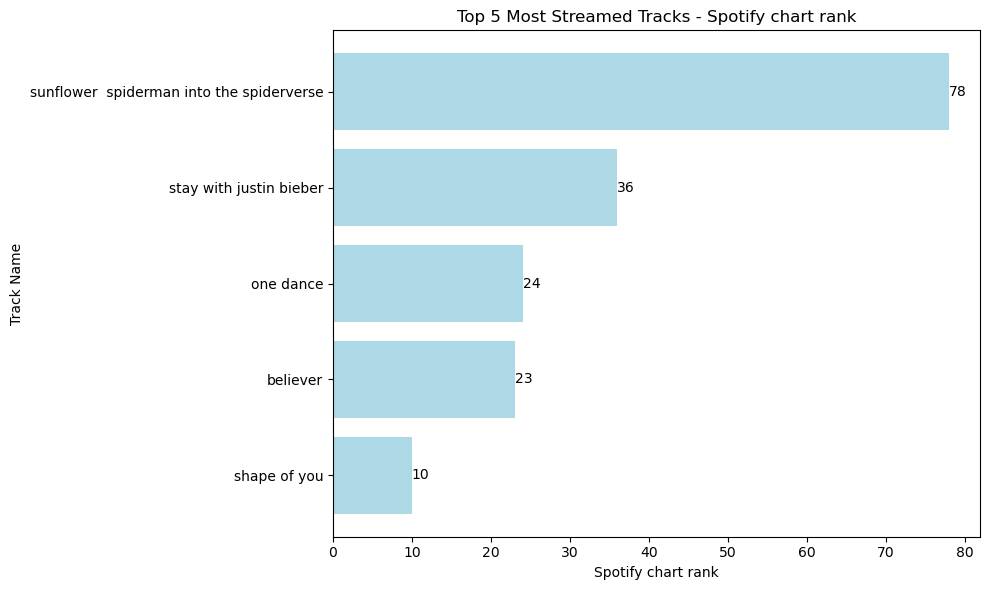

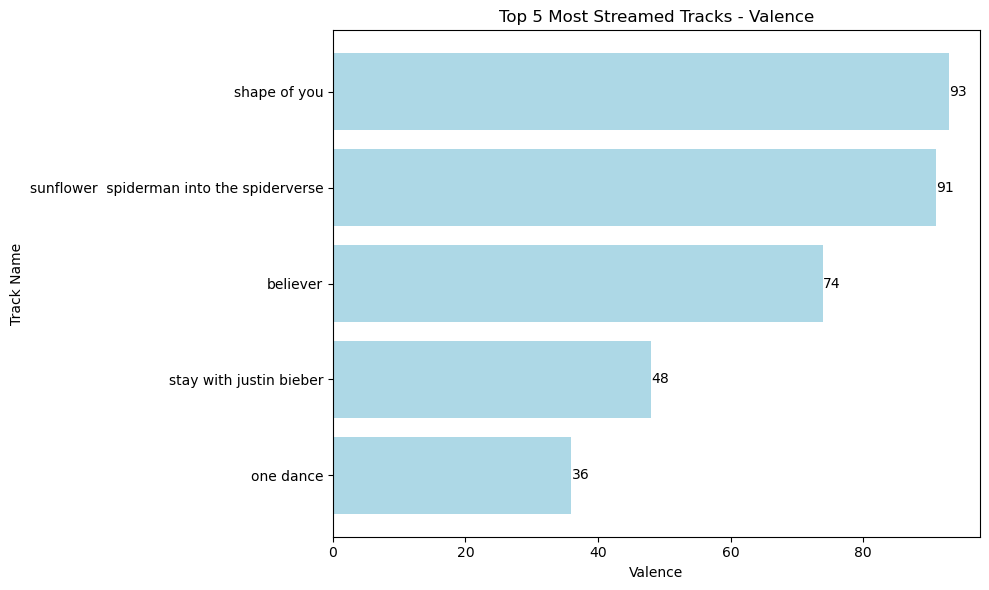

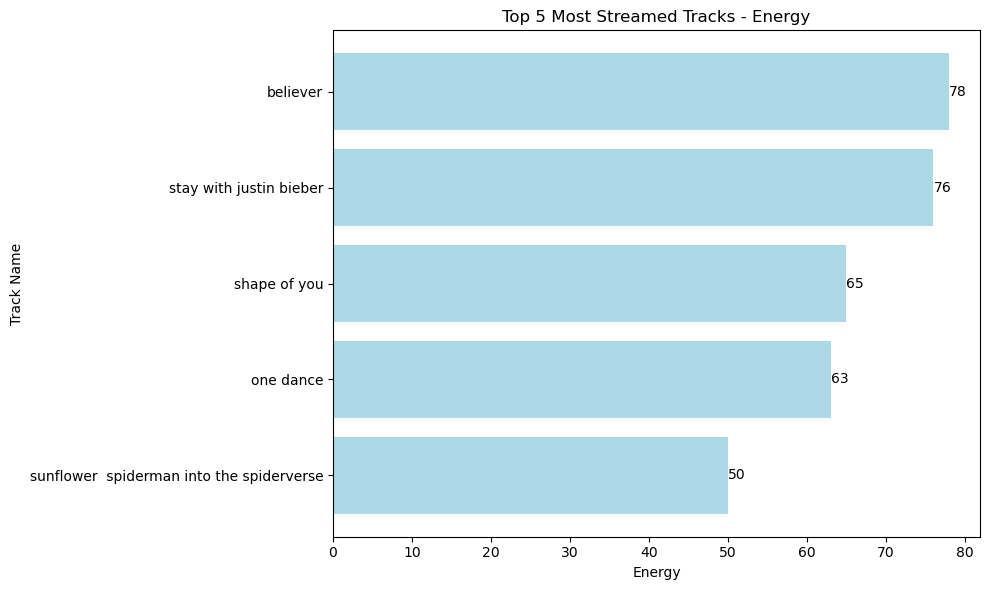

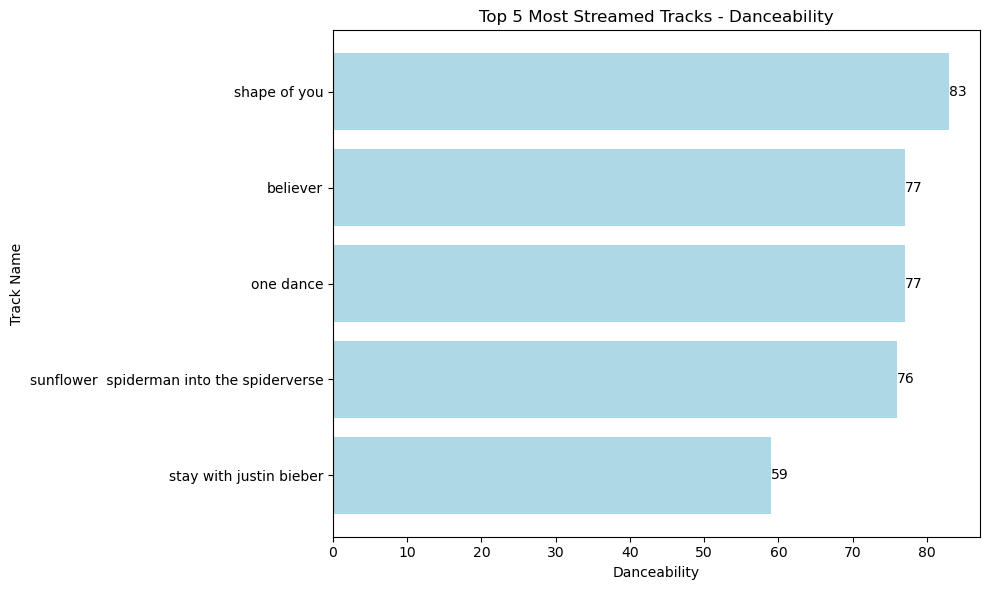

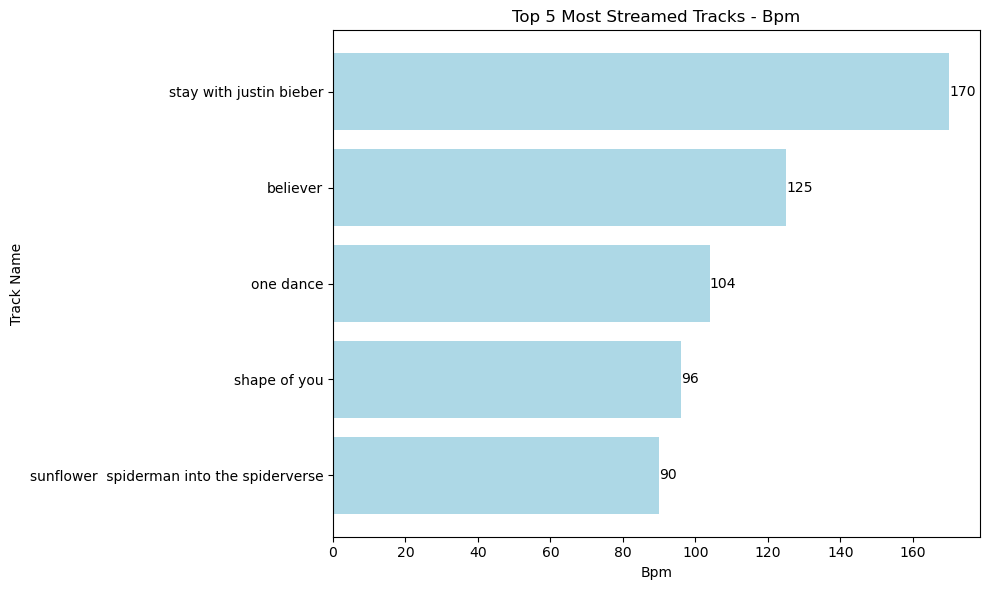

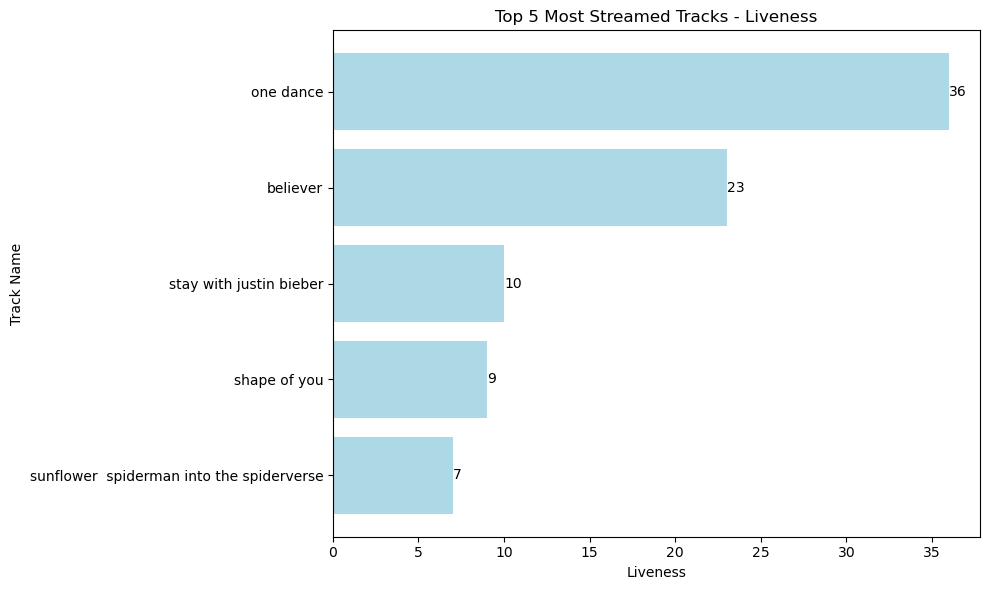

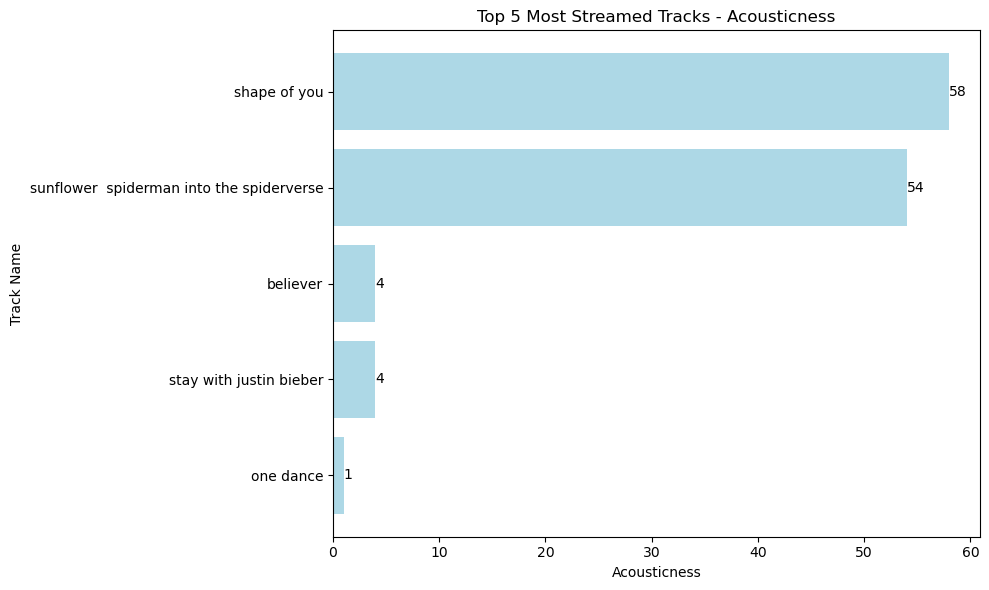

In [41]:
# Sort the DataFrame by 'streams' in descending order to get the top 5 most streamed tracks
sorted_df = cleaned_spotify_df.sort_values(by='streams', ascending=False)

# Select the top 5 most streamed tracks and include the audio qualities and features of streaming
top_streamed_tracks = sorted_df[['track_name', 'artists_name', 'streams', 
                                 'in_spotify_playlists', 'in_apple_playlists', 
                                 'released_year', 'in_deezer_playlists', 
                                 'spotify_chart_rank', 'valence', 'energy', 
                                 'danceability', 'bpm', 'liveness', 'acousticness']].head(5)

# Features to generate bar graphs for
features = ['in_spotify_playlists', 'in_apple_playlists', 'released_year', 
            'in_deezer_playlists', 'spotify_chart_rank', 'valence', 
            'energy', 'danceability', 'bpm', 'liveness', 'acousticness']

# Function to plot a bar graph for each feature dynamically from the DataFrame
def plot_feature_bar_graphs(top_streamed_tracks, features):
    for feature in features:
        # Sort the DataFrame by the current feature in descending order
        sorted_tracks = top_streamed_tracks.sort_values(by=feature, ascending=True)
        
        plt.figure(figsize=(10, 6))
        
        # Create a horizontal bar graph for each feature
        plt.barh(sorted_tracks['track_name'], sorted_tracks[feature], color='lightblue')
        
        # Add labels and title
        plt.xlabel(feature.replace('_', ' ').capitalize())
        plt.ylabel('Track Name')
        plt.title(f'Top 5 Most Streamed Tracks - {feature.replace("_", " ").capitalize()}')
        
        # Annotate bars with the values
        for index, value in enumerate(sorted_tracks[feature]):
            plt.text(value, index, f'{value}', va='center')
        
        # Show the plot
        plt.tight_layout()
        plt.show()

# Call the function to plot the bar graphs for all features
plot_feature_bar_graphs(top_streamed_tracks, features)
